In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import spacy
#pd.set_option('display.max_colwidth', None)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
#load preprocessed data
preprocessed_data = pd.read_csv('Ukraine_v2_preprocessed.csv')
preprocessed_data.head()

article_title  \
0    NATO, US put Ukraine’s EU membership in dilemma   
1  Xi offers answers to questions of the times at...   
2        Wild ambition of NATO against public’s will   
3                                    Title not found   
4  Egyptian Red Sea resort Sharm el-Sheikh reels ...   

                                              author  \
0                                    By Global Times   
1  By \n\n\n\n\n Yang Sheng \nYang Sheng is a chi...   
2                                          By Lu Xue   
3                                   Author not found   
4                                         By Reuters   

                     published_time  \
0  Published: Jun 22, 2022 11:21 PM   
1  Published: Jun 23, 2022 12:07 AM   
2  Published: Jun 23, 2022 12:23 AM   
3          Published time not found   
4  Published: Jun 23, 2022 04:10 PM   

                                        article_text Unnamed: 4 Unnamed: 5  \
0  Illustration: Chen Xian/Global TimesUkraine is...        NaN        NaN   
1  Chinese President Xi Jinping delivers a keynot...        NaN        NaN   
2  Illustration: Liu Rui/Global TimesEditor's Not...        NaN        NaN   
3                             Article text not found        NaN        NaN   
4  A picture taken on September 29, 2021 shows Ru...        NaN        NaN   

  Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 144 Unnamed: 145  \
0        NaN        NaN        NaN        NaN  ...          NaN          NaN   
1        NaN        NaN        NaN        NaN  ...          NaN          NaN   
2        NaN        NaN        NaN        NaN  ...          NaN          NaN   
3        NaN        NaN        NaN        NaN  ...          NaN          NaN   
4        NaN        NaN        NaN        NaN  ...          NaN          NaN   

  Unnamed: 146 Unnamed: 147 Unnamed: 148 Unnamed: 149 Unnamed: 150  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

  Unnamed: 151 Unnamed: 152 Unnamed: 153  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN  

[5 rows x 154 columns]

In [ ]:
#load top 50 words for each entity type from the NER results
ner_results = pd.read_excel('Ukraine_v2_TopWords.xlsx')
ner_results.head()

Entity Type                Word  Count
0         PER           Joe Biden    563
1         PER      Vladimir Putin    431
2         PER             Wang Yi    320
3         PER  Volodymyr Zelensky    309
4         PER          Xi Jinping    156

In [ ]:
#filtering top 10 entities for each type
#top_5 = ner_results.groupby('Entity Type').head(5)
#top_5.head()
misc_indices = [0, 1, 9, 10, 12]
top_5 = ner_results[ner_results['Entity Type'] != 'MISC'].groupby('Entity Type').head(5)
top_misc = ner_results[(ner_results['Entity Type'] == 'MISC')].iloc[misc_indices]

# Combine the results
top_5 = pd.concat([top_5, top_misc])
top_5.head()

Entity Type                Word  Count
0         PER           Joe Biden    563
1         PER      Vladimir Putin    431
2         PER             Wang Yi    320
3         PER  Volodymyr Zelensky    309
4         PER          Xi Jinping    156

In [ ]:
#combine top 10 into single list of entities
entities = top_5['Word'].tolist()
entities

['Joe Biden',
 'Vladimir Putin',
 'Wang Yi',
 'Volodymyr Zelensky',
 'Xi Jinping',
 'EU',
 'NATO',
 'Global Times',
 'UN',
 'EU Commission',
 'China',
 'Ukraine',
 'US',
 'Russia',
 'India',
 'West',
 'Cold War',
 'COVID',
 'Afghan',
 'World War II']

## Relationship with co-occurence based in same sentence using networkx

In [ ]:
#initiliazise graph
G = nx.Graph()

#add nodes for each entity
for entity in entities:
    G.add_node(entity)

In [ ]:
co_occurrence = defaultdict(int)

In [ ]:
for article in preprocessed_data['article_text']:
    #process the article with SpaCy to get sentences
    doc = nlp(article)
    sentences = [sent.text for sent in doc.sents]
    #print(sentences)

    #iterate through each sentence in the article
    for sentence in sentences:
        present_entities = [entity for entity in entities if entity in sentence]
        #print(present_entities)
        for i in range(len(present_entities)):
            for j in range(i + 1, len(present_entities)):
                co_occurrence[(present_entities[i], present_entities[j])] += 1
                #print(co_occurrence)

In [ ]:
#add edges with weights to the graph
for (entity1, entity2), weight in co_occurrence.items():
    G.add_edge(entity1, entity2, weight=weight)

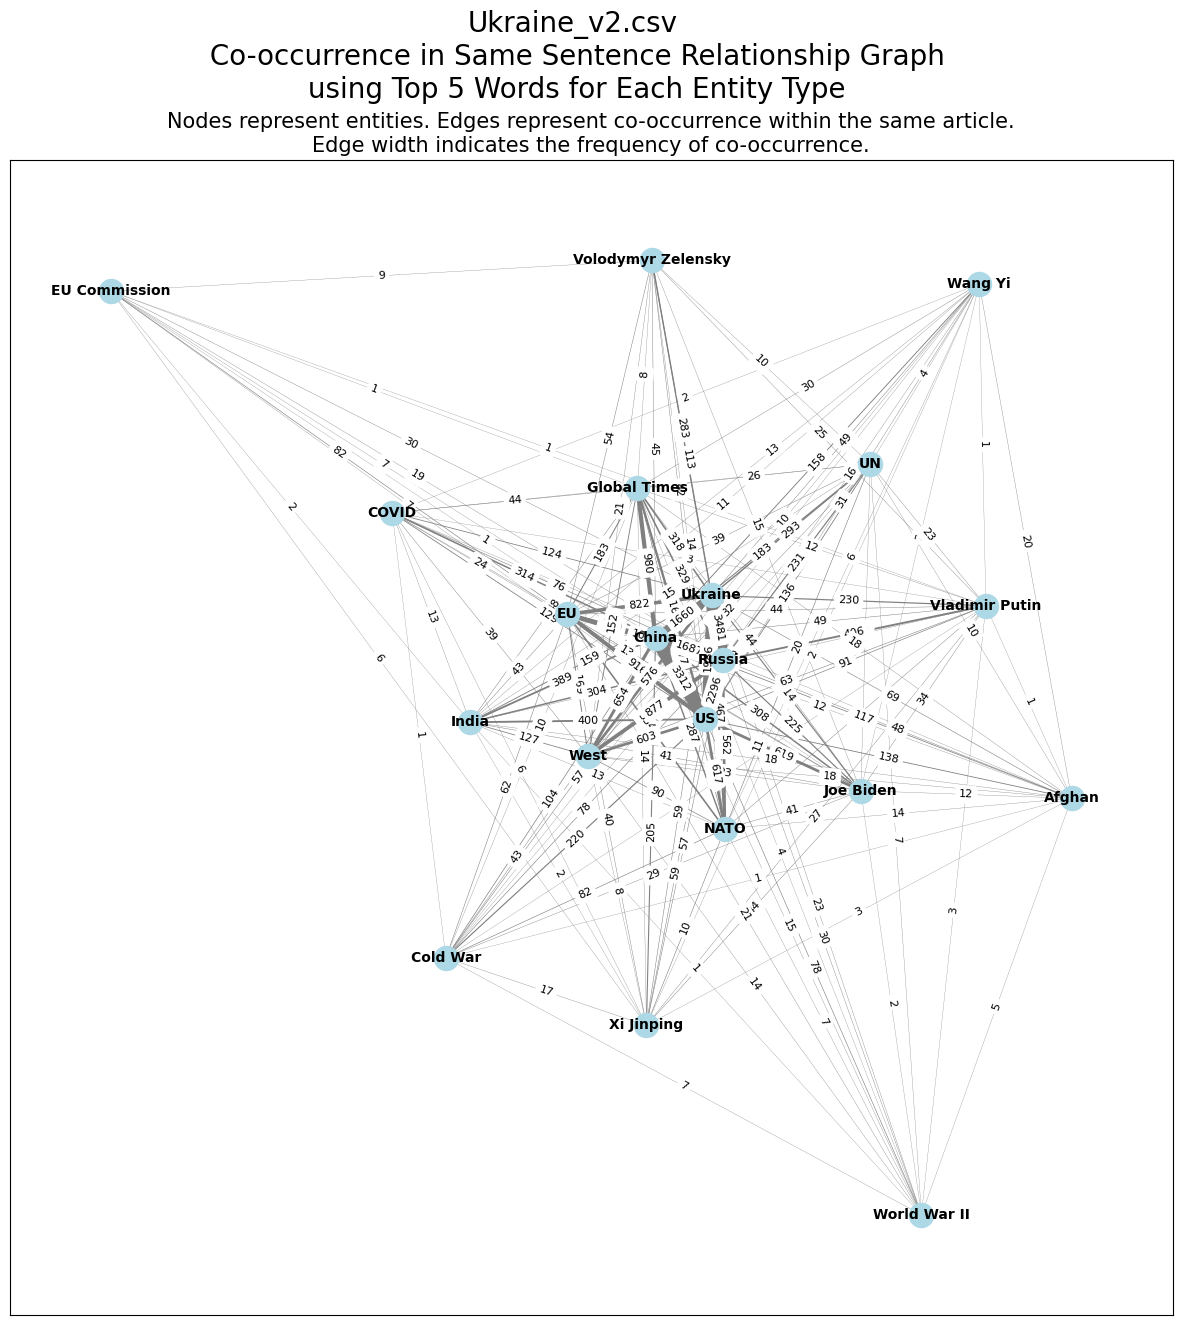

In [ ]:
#draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

max_weight = max(weights)
min_width = 0.2
normalized_weights = [(weight / max_weight * 10) + min_width for weight in weights]

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=normalized_weights, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
#nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray', font_size=10, font_weight='bold', width=weights)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.suptitle("Ukraine_v2.csv\n Co-occurrence in Same Sentence Relationship Graph\n using Top 5 Words for Each Entity Type", fontsize=20)
plt.title("Nodes represent entities. Edges represent co-occurrence within the same article.\nEdge width indicates the frequency of co-occurrence.", fontsize=15)
plt.show()

In [ ]:
#edges

---
## Relationship with co-occurence based in same article using networkx

In [ ]:
#initialize graph
G = nx.Graph()

#add nodes for each entity
for entity in entities:
    G.add_node(entity)

In [ ]:
co_occurrence = defaultdict(int)

#iterate through each article in the preprocessed dataset
for article in preprocessed_data['article_text']:
    #find all entities present in the article
    present_entities = [entity for entity in entities if entity in article]
    #print(present_entities)

    #track co-occurrences within the article
    for i in range(len(present_entities)):
        for j in range(i + 1, len(present_entities)):
            co_occurrence[(present_entities[i], present_entities[j])] += 1
            #print(co_occurrence)

In [ ]:
#add edges with weights to the graph
for (entity1, entity2), weight in co_occurrence.items():
    G.add_edge(entity1, entity2, weight=weight)

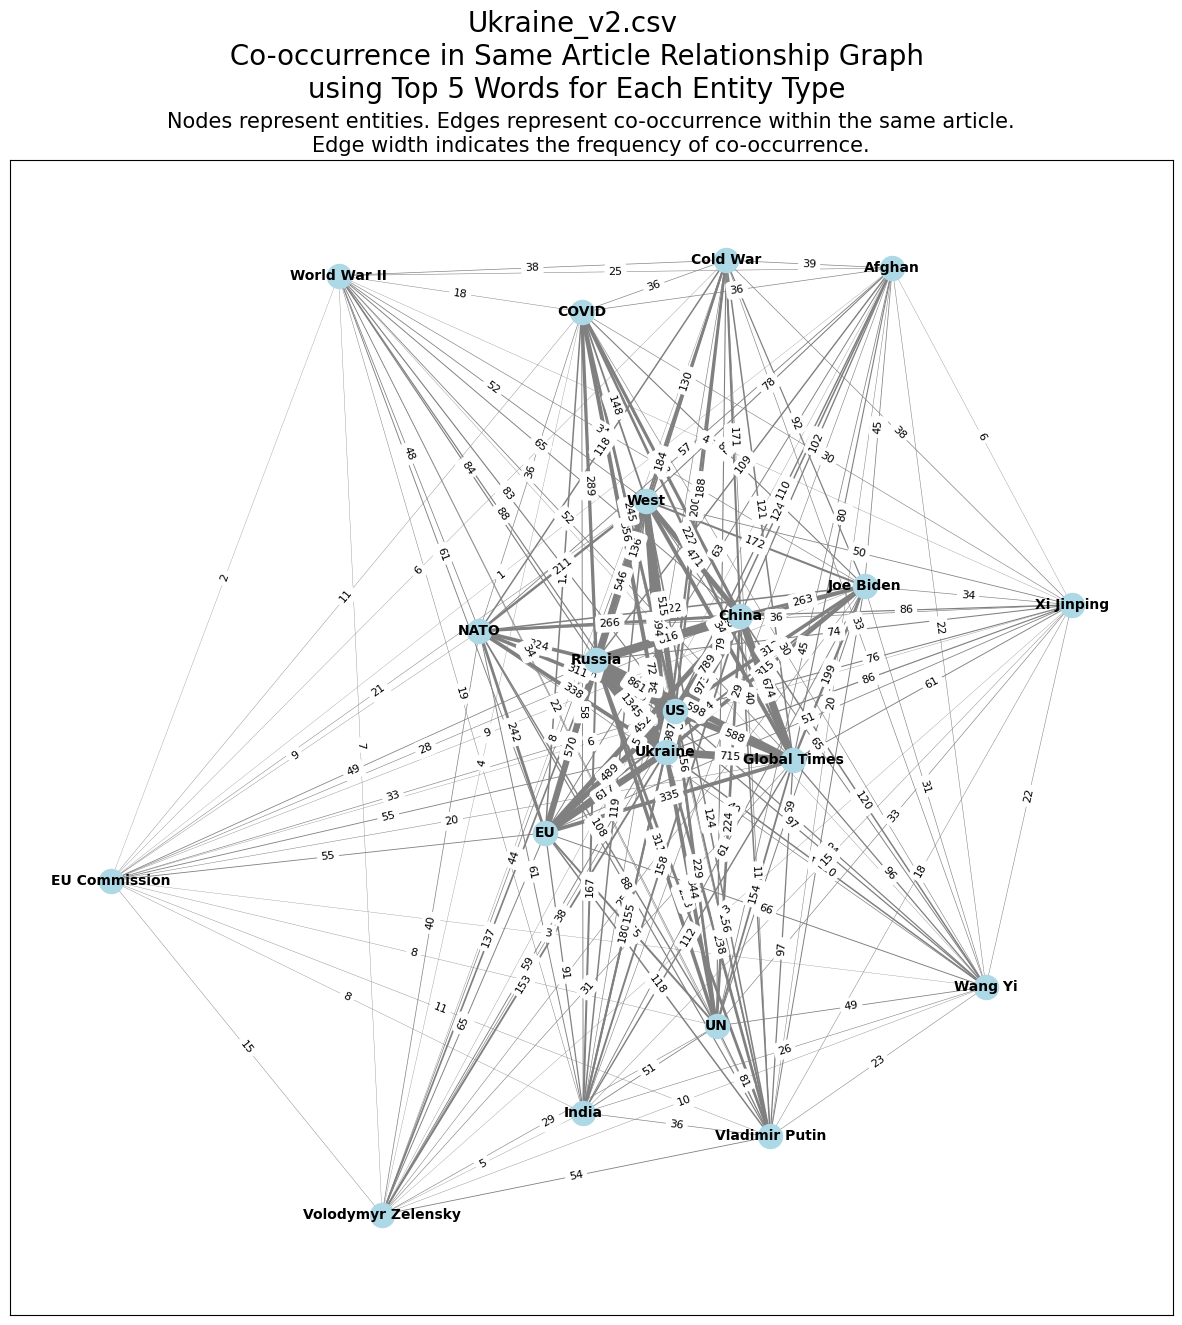

In [ ]:
#draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

max_weight = max(weights)
min_width = 0.2
normalized_weights = [(weight / max_weight * 10) + min_width for weight in weights]

nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=normalized_weights, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
#nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray', font_size=10, font_weight='bold', width=weights)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.suptitle("Ukraine_v2.csv\n Co-occurrence in Same Article Relationship Graph\n using Top 5 Words for Each Entity Type", fontsize=20)
plt.title("Nodes represent entities. Edges represent co-occurrence within the same article.\nEdge width indicates the frequency of co-occurrence.", fontsize=15)
plt.show()

---
## Relationship with co-occurence based in same sentence using hypergraph

In [ ]:
pip install hypernetx

In [ ]:
import hypernetx as hnx
import matplotlib.pyplot as plt

In [ ]:
entities = list(set(entity.lower() for entity in entities_of_interest))
entities

['wang yi',
 'covid',
 'afghan',
 'eu',
 'us',
 'un',
 'joe biden',
 'china',
 'xi jinping',
 'west',
 'russia',
 'world war ii',
 'global times',
 'india',
 'vladimir putin',
 'nato',
 'eu commission',
 'ukraine',
 'volodymyr zelensky',
 'cold war']

In [ ]:
#function to find co-occurrences within sentences
def find_cooccurrences(text, entities):
    doc = nlp(text)
    co_occurrences = []

    for sent in doc.sents:
        sent_entities = [entity for entity in entities if entity in sent.text.lower()]
        if len(sent_entities) > 1:
            co_occurrences.append(tuple(sent_entities))

    return co_occurrences

In [ ]:
hyperedges = []

for article in preprocessed_data['article_text']:
    co_occurrences = find_cooccurrences(article, entities)
    hyperedges.extend(co_occurrences)

In [ ]:
hyperedges

[('eu', 'us', 'global times', 'ukraine'),
 ('eu', 'un'),
 ('eu', 'us', 'un', 'russia', 'ukraine'),
 ('eu', 'us', 'nato'),
 ('us', 'west', 'ukraine'),
 ('eu', 'china', 'global times', 'nato', 'ukraine'),
 ('eu', 'us', 'un', 'russia', 'vladimir putin', 'nato', 'ukraine'),
 ('eu', 'us', 'un', 'west', 'ukraine'),
 ('eu', 'un', 'ukraine'),
 ('us', 'un', 'china', 'ukraine'),
 ('eu', 'un'),
 ('eu', 'us', 'un', 'russia'),
 ('eu', 'un'),
 ('eu', 'ukraine'),
 ('eu', 'un', 'ukraine'),
 ('eu', 'ukraine'),
 ('eu', 'un', 'vladimir putin', 'ukraine'),
 ('un', 'ukraine'),
 ('eu', 'ukraine'),
 ('us', 'un', 'china', 'xi jinping'),
 ('us', 'un', 'xi jinping', 'ukraine'),
 ('un', 'xi jinping'),
 ('us', 'un', 'china', 'west', 'nato'),
 ('us', 'china', 'russia', 'nato'),
 ('us', 'un', 'china'),
 ('un', 'xi jinping'),
 ('us', 'russia', 'india', 'vladimir putin'),
 ('us', 'china', 'west'),
 ('us', 'xi jinping'),
 ('us', 'xi jinping'),
 ('eu', 'us', 'un', 'china', 'west', 'russia', 'nato', 'ukraine'),
 ('us', 

In [ ]:
#remove duplicate hyperedges
#hyperedges = list(map(list, set(map(tuple, hyperedges))))
#hyperedges

In [ ]:
#count the frequency of each hyperedge
hyperedge_counter = Counter(map(tuple, hyperedges))
hyperedge_counter

Counter({('eu', 'us', 'global times', 'ukraine'): 2,
         ('eu', 'un'): 204,
         ('eu', 'us', 'un', 'russia', 'ukraine'): 116,
         ('eu', 'us', 'nato'): 50,
         ('us', 'west', 'ukraine'): 23,
         ('eu', 'china', 'global times', 'nato', 'ukraine'): 1,
         ('eu', 'us', 'un', 'russia', 'vladimir putin', 'nato', 'ukraine'): 1,
         ('eu', 'us', 'un', 'west', 'ukraine'): 3,
         ('eu', 'un', 'ukraine'): 50,
         ('us', 'un', 'china', 'ukraine'): 90,
         ('eu', 'us', 'un', 'russia'): 185,
         ('eu', 'ukraine'): 76,
         ('eu', 'un', 'vladimir putin', 'ukraine'): 1,
         ('un', 'ukraine'): 374,
         ('us', 'un', 'china', 'xi jinping'): 15,
         ('us', 'un', 'xi jinping', 'ukraine'): 1,
         ('un', 'xi jinping'): 22,
         ('us', 'un', 'china', 'west', 'nato'): 4,
         ('us', 'china', 'russia', 'nato'): 14,
         ('us', 'un', 'china'): 1088,
         ('us', 'russia', 'india', 'vladimir putin'): 3,
         ('us', 

In [ ]:
filtered_hyperedges = [list(edge) for edge, count in hyperedge_counter.items() if count > 20]
filtered_hyperedges

[['eu', 'un'],
 ['eu', 'us', 'un', 'russia', 'ukraine'],
 ['eu', 'us', 'nato'],
 ['us', 'west', 'ukraine'],
 ['eu', 'un', 'ukraine'],
 ['us', 'un', 'china', 'ukraine'],
 ['eu', 'us', 'un', 'russia'],
 ['eu', 'ukraine'],
 ['un', 'ukraine'],
 ['un', 'xi jinping'],
 ['us', 'un', 'china'],
 ['us', 'china', 'west'],
 ['us', 'un'],
 ['covid', 'us', 'un'],
 ['us', 'un', 'global times'],
 ['us', 'un', 'west'],
 ['us', 'china'],
 ['china', 'west'],
 ['us', 'russia', 'nato', 'ukraine'],
 ['us', 'west', 'russia'],
 ['west', 'ukraine'],
 ['us', 'west', 'russia', 'ukraine'],
 ['us', 'un', 'west', 'russia'],
 ['us', 'west'],
 ['us', 'un', 'china', 'russia', 'global times'],
 ['us', 'russia'],
 ['un', 'nato', 'ukraine'],
 ['eu', 'us', 'china', 'russia', 'ukraine'],
 ['un', 'nato'],
 ['us', 'un', 'china', 'nato'],
 ['us', 'russia', 'ukraine'],
 ['us', 'un', 'russia', 'ukraine'],
 ['us', 'un', 'west', 'ukraine'],
 ['us', 'un', 'russia'],
 ['eu', 'us', 'un'],
 ['us', 'global times'],
 ['un', 'china', 'g

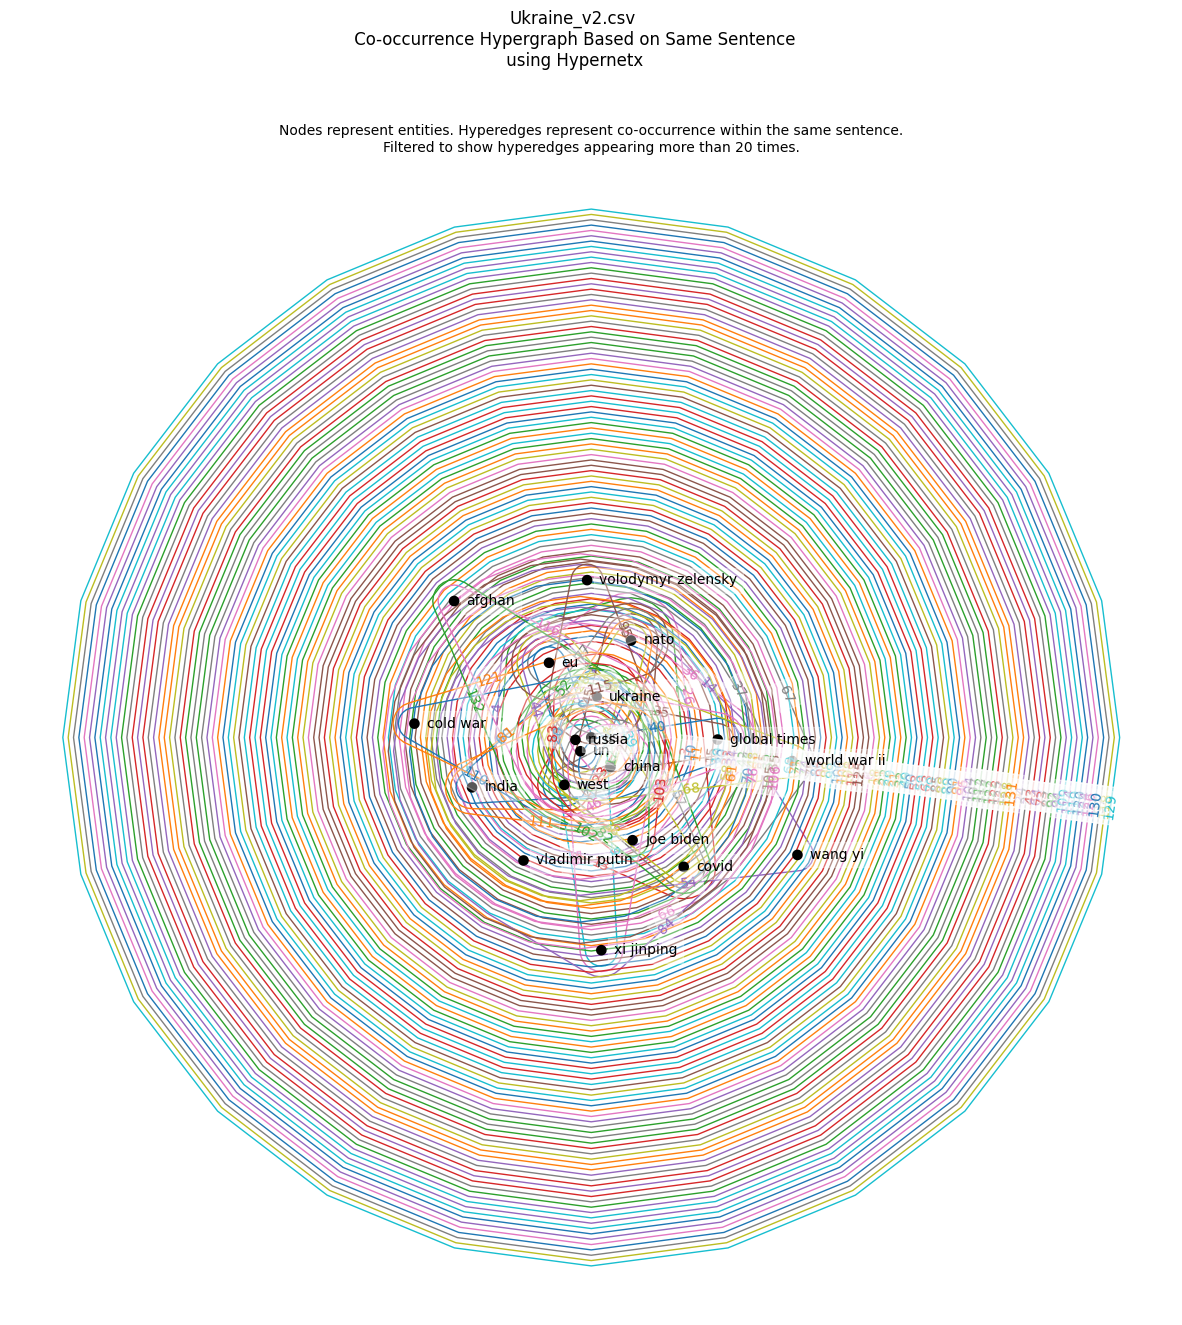

In [ ]:
H = hnx.Hypergraph(filtered_hyperedges)

plt.figure(figsize=(15, 15))
hnx.draw(H, with_node_labels=True, with_edge_labels=True)
plt.suptitle("Ukraine_v2.csv\n Co-occurrence Hypergraph Based on Same Sentence\n using Hypernetx")
plt.title("Nodes represent entities. Hyperedges represent co-occurrence within the same sentence.\nFiltered to show hyperedges appearing more than 20 times.", fontsize=10)
plt.show()

---
## Relationship with co-occurence based in same article using hypergraph

In [ ]:
def find_cooccurrences(text, entities):
    doc = nlp(text)
    doc_text = doc.text.lower()
    co_occurrences = []

    article_entities = [entity for entity in entities if entity in doc_text]
    if len(article_entities) > 1:
        co_occurrences.append(tuple(article_entities))

    return co_occurrences

In [ ]:
hyperedges = []

for article in preprocessed_data['article_text']:
    co_occurrences = find_cooccurrences(article, entities)
    hyperedges.extend(co_occurrences)

In [ ]:
hyperedges

[('eu',
  'us',
  'un',
  'china',
  'west',
  'russia',
  'global times',
  'vladimir putin',
  'nato',
  'ukraine'),
 ('wang yi',
  'covid',
  'eu',
  'us',
  'un',
  'china',
  'xi jinping',
  'west',
  'russia',
  'global times',
  'india',
  'vladimir putin',
  'nato',
  'ukraine'),
 ('eu',
  'us',
  'un',
  'china',
  'west',
  'russia',
  'global times',
  'nato',
  'ukraine'),
 ('covid', 'us', 'un', 'west', 'russia', 'ukraine'),
 ('eu',
  'us',
  'un',
  'china',
  'xi jinping',
  'west',
  'russia',
  'india',
  'vladimir putin',
  'nato',
  'ukraine'),
 ('afghan', 'us', 'un', 'russia', 'ukraine'),
 ('eu', 'us', 'un', 'china', 'russia', 'ukraine'),
 ('covid', 'us', 'un', 'china', 'russia', 'global times', 'ukraine'),
 ('eu',
  'us',
  'un',
  'china',
  'west',
  'russia',
  'global times',
  'vladimir putin',
  'nato',
  'ukraine'),
 ('eu', 'us', 'un', 'russia', 'ukraine'),
 ('eu',
  'us',
  'un',
  'china',
  'west',
  'russia',
  'global times',
  'nato',
  'ukraine'),
 ('w

In [ ]:
hyperedge_counter = Counter(map(tuple, hyperedges))
hyperedge_counter

Counter({('eu',
          'us',
          'un',
          'china',
          'west',
          'russia',
          'global times',
          'vladimir putin',
          'nato',
          'ukraine'): 5,
         ('wang yi',
          'covid',
          'eu',
          'us',
          'un',
          'china',
          'xi jinping',
          'west',
          'russia',
          'global times',
          'india',
          'vladimir putin',
          'nato',
          'ukraine'): 1,
         ('eu',
          'us',
          'un',
          'china',
          'west',
          'russia',
          'global times',
          'nato',
          'ukraine'): 9,
         ('covid', 'us', 'un', 'west', 'russia', 'ukraine'): 3,
         ('eu',
          'us',
          'un',
          'china',
          'xi jinping',
          'west',
          'russia',
          'india',
          'vladimir putin',
          'nato',
          'ukraine'): 1,
         ('afghan', 'us', 'un', 'russia', 'ukraine'): 2,

In [ ]:
filtered_hyperedges = [list(edge) for edge, count in hyperedge_counter.items() if count > 5]
filtered_hyperedges

[['eu',
  'us',
  'un',
  'china',
  'west',
  'russia',
  'global times',
  'nato',
  'ukraine'],
 ['eu', 'us', 'un', 'china', 'russia', 'ukraine'],
 ['covid', 'us', 'un', 'china', 'russia', 'global times', 'ukraine'],
 ['eu', 'us', 'un', 'russia', 'ukraine'],
 ['covid', 'us', 'un', 'russia', 'ukraine'],
 ['covid', 'us', 'un', 'ukraine'],
 ['eu', 'us', 'un', 'west', 'russia', 'ukraine'],
 ['covid', 'eu', 'us', 'un', 'china', 'russia', 'global times', 'ukraine'],
 ['us', 'un', 'china', 'global times', 'ukraine'],
 ['eu', 'us', 'un', 'russia', 'ukraine', 'volodymyr zelensky'],
 ['us', 'un', 'russia', 'ukraine', 'volodymyr zelensky'],
 ['us', 'un', 'china', 'russia', 'global times', 'ukraine'],
 ['eu', 'us', 'un', 'china', 'russia', 'global times', 'ukraine'],
 ['us', 'un', 'ukraine'],
 ['us', 'un', 'russia', 'ukraine'],
 ['eu', 'us', 'un', 'ukraine'],
 ['covid', 'us', 'un', 'china', 'west', 'russia', 'global times', 'ukraine'],
 ['eu', 'us', 'un', 'china', 'west', 'russia', 'global time

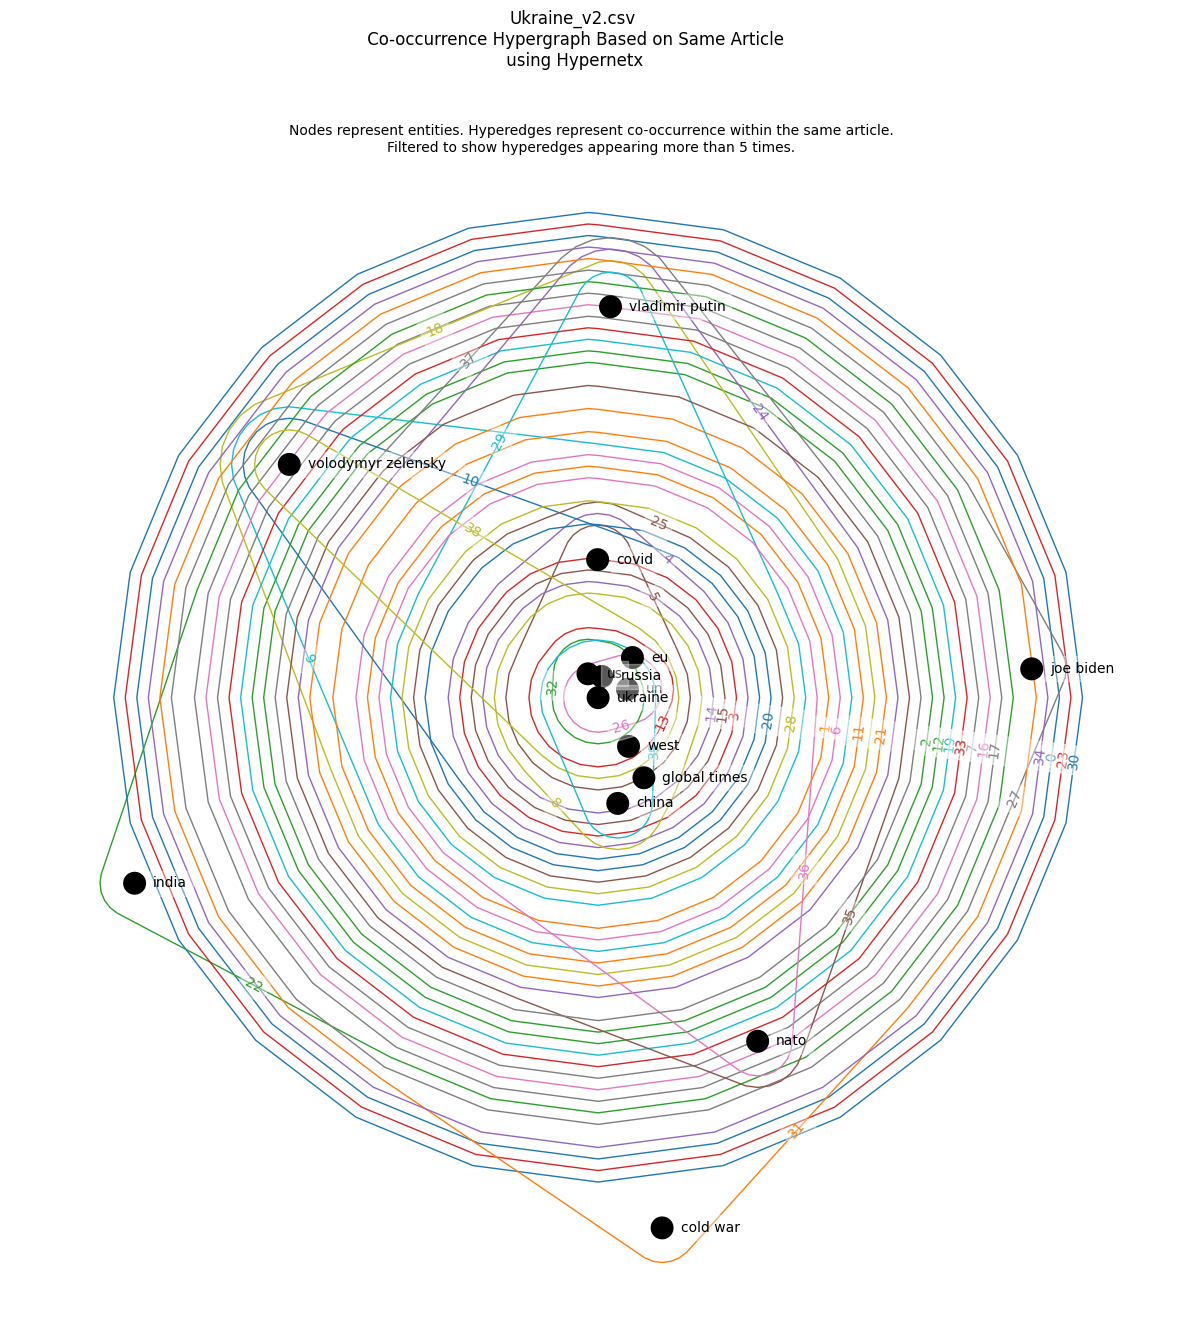

In [ ]:
H = hnx.Hypergraph(filtered_hyperedges)

plt.figure(figsize=(15, 15))
hnx.draw(H, with_node_labels=True, with_edge_labels=True)
plt.suptitle("Ukraine_v2.csv\n Co-occurrence Hypergraph Based on Same Article\n using Hypernetx")
plt.title("Nodes represent entities. Hyperedges represent co-occurrence within the same article.\nFiltered to show hyperedges appearing more than 5 times.", fontsize=10)
plt.show()